#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/csl.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns sentiment RBA FED
N=3
df = df_stock_less1.iloc[: , :-N]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/01/2000,7.300000,7.300000,7.300000,7.300000,5.234562,0.0
1,4/01/2000,7.333333,7.333333,7.066666,7.186666,5.153295,254295.0
2,5/01/2000,7.000000,7.183333,7.000000,7.155000,5.130589,424941.0
3,6/01/2000,7.233333,7.273333,7.000000,7.000000,5.019443,348534.0
4,7/01/2000,7.013000,7.023333,6.800000,6.850000,4.911883,483963.0


<AxesSubplot:>

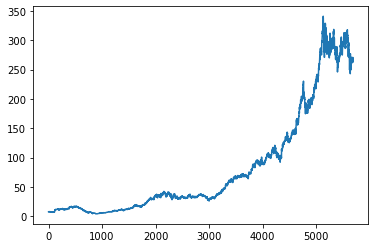

In [3]:
df["Close"].plot()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5649 entries, 0 to 5683
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5649 non-null   object 
 1   Open       5649 non-null   float64
 2   High       5649 non-null   float64
 3   Low        5649 non-null   float64
 4   Close      5649 non-null   float64
 5   Adj Close  5649 non-null   float64
 6   Volume     5649 non-null   float64
dtypes: float64(6), object(1)
memory usage: 353.1+ KB


In [5]:
data = df.filter(['Close'])
dataset = data.values
dataset.shape


(5649, 1)

# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [6]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4520, 1)

In [7]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.01017412, 0.00983794, 0.00974402, 0.00928425, 0.00883932,
       0.01027299, 0.01022355, 0.01047074, 0.01037186, 0.01072781,
       0.01096511, 0.01091567, 0.01096511, 0.01141004, 0.01101454,
       0.01086623, 0.01081581, 0.01145948, 0.01126173, 0.01135368,
       0.01145948, 0.01150891, 0.01154846, 0.01155835, 0.01160779,
       0.01096511, 0.01111342, 0.01126173, 0.01056961, 0.01041141,
       0.01037186, 0.01003569, 0.00937719, 0.00899653, 0.00903707,
       0.00898763, 0.00898763, 0.00943256, 0.00933369, 0.009482  ,
       0.01007524, 0.00999515, 0.009482  , 0.00862773, 0.00918538,
       0.00928425, 0.00898763, 0.00903707, 0.0097806 , 0.00997637,
       0.00997637, 0.00997637, 0.01037186, 0.01032243, 0.01039362,
       0.01056961, 0.01066848, 0.01047074, 0.01027299, 0.01047074])]
[0.010477658470026397]


# Prepare train data for LSTM model

In [8]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4460, 60)

In [9]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4460, 60, 1)

# Build the LSTM model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [12]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4460/4460 [==============================] - 67s 15ms/step - loss: 1.2899e-04


In [13]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [14]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [15]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [16]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

3.255504837670055

C:\Users\antoi\AppData\Local\Temp/ipykernel_18688/4002722267.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


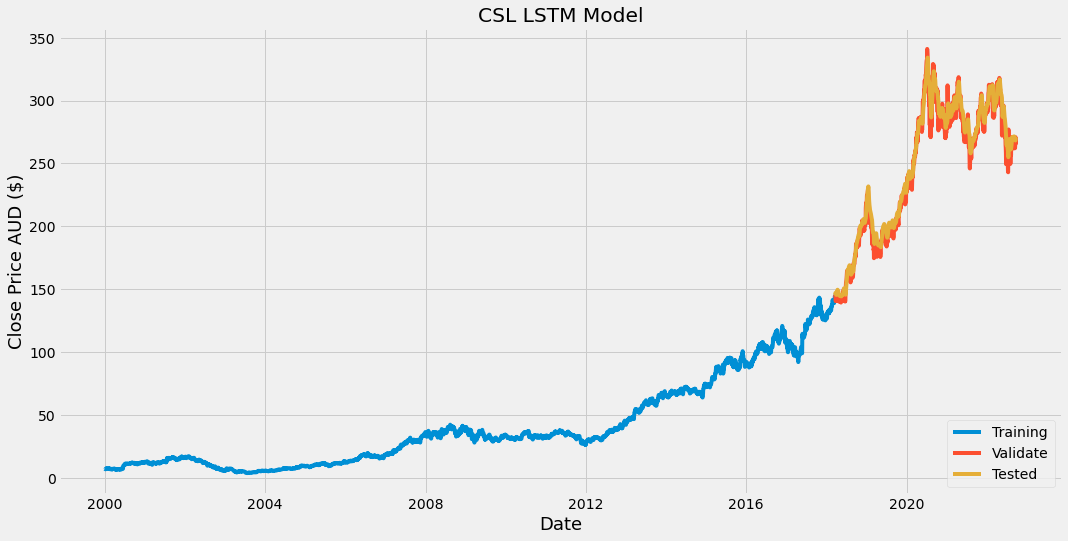

In [17]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('CSL LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.show()


# Test data Predictions on the Model

In [18]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_18688/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4555,145.779999,145.673752,0.106247
4556,144.000000,146.566147,-2.566147
4557,143.619995,147.063965,-3.443970
4558,140.789993,147.263443,-6.473450
4559,141.250000,146.856232,-5.606232
...,...,...,...
5679,266.980011,268.254456,-1.274445
5680,270.859985,268.686951,2.173034
5681,269.339996,269.863922,-0.523926
5682,265.890015,270.884552,-4.994537


In [19]:
#Get latest 60 quotes less 1 to predict:

#import pandas_datareader.data as web
#symbol = 'CSL.AX'
#stock_quote = web.DataReader(symbol,data_source='yahoo',start='2022-01-01', end='2022-04-13')
#stock_quotes_sixty = stock_quotes_sixty.filter(['Close'])
#stock_quotes_sixty
#OR use csv data 

In [20]:
# Use last 60 days price on model to predict next days price
stock_quotes_sixty = df_stock_less1.tail(60)
stock_close_sixty = stock_quotes_sixty['Close']
last_60_days = stock_close_sixty[-60:].values
last_60_days = last_60_days.reshape(-1,1)
last_60_days.shape

(60, 1)

In [21]:
last_60_days_scaled = scaler.transform(last_60_days)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [22]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'Predicted next day share price {pred_price}')

Predicted next day share price 271


In [23]:
#stock_quote_acual = web.DataReader('CSL.AX',data_source='yahoo',start='2022-04-14', end='2022-04-14')
#OR get last quote from latest csv
stock_quote_last_one = df_stock1.tail(1)
stock_quote_last_one

,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED
5684,29/04/2022,269.0,271.420013,268.630005,270.869995,270.869995,294024.0,NEGATIVE,0.05,0.08


In [24]:
#save actual to variable
actual_price = stock_quote_last_one.iloc[0,4]
actual_date = stock_quote_last_one.iloc[0,0] 
actual_price = int(actual_price)
actual_price
actual_date

'29/04/2022'

# Save the Model

In [25]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/csl_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list csl_sixty and load df

In [26]:
# Read in the CSV file
df_csl_sixty = pd.read_csv("../static/data/csl_sixty.csv")
df_csl_sixty.head()

,260.109192
0,260.974426
1,256.041718
2,257.364410
3,253.207428
4,255.564377


In [27]:
close_sixty_val = df_csl_sixty[-60:].values
last_sixty = close_sixty_val.reshape(-1,1)
last_sixty.shape

(60, 1)

In [28]:
last_sixty_scaled = scaler.transform(last_sixty)
new_X_tell = []
new_X_tell.append(last_sixty_scaled)
new_X_tell =np.array(new_X_tell)
new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
new_X_tell.shape

(1, 60, 1)

#PREDICT USING LOADED MODEL

In [29]:
from keras.models import load_model
model_in = load_model('../static/csl_model.sav')

In [30]:
model_in_pd_scale = model_in.predict(new_X_tell)
model_in_pd_scale

array([[0.7959807]], dtype=float32)

In [31]:
model_in_price = scaler.inverse_transform(model_in_pd_scale)
#model_in_price_int = int(model_in_price)
print(f'Predicted next day share price {model_in_price}')

Predicted next day share price [[272.21896]]


In [32]:
last_sixty_less_one = np.delete(last_sixty, 0, 0)
last_sixty_less_one.shape

(59, 1)

In [33]:
last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0)
last_sixty.shape

(60, 1)

#Create a function to loop through the days input

In [34]:
from keras.models import load_model
model_in = load_model('../static/csl_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# Read in the CSV file
df_csl_sixty = pd.read_csv("../static/data/csl_sixty.csv")
close_sixty_val = df_csl_sixty[-60:].values
last_sixty = close_sixty_val.reshape(-1,1)
price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 1
else:
   input = int(input)

def predict_csl(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    print(price_list)

In [35]:
predict_csl(last_sixty,model_in,input)

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

In [37]:
#input = 10
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df_iloc = dates_df.iloc[0:input-1]
dates_df_iloc['Price'] = price_list
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict

C:\Users\antoi\AppData\Local\Temp/ipykernel_18688/1272003391.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


[{'Count': 1.0, 'Date': '3/05/2022', 'DOW': 'Tuesday', 'Price': 268.56},
 {'Count': 2.0, 'Date': '4/05/2022', 'DOW': 'Wednesday', 'Price': 268.86},
 {'Count': 3.0, 'Date': '5/05/2022', 'DOW': 'Thursday', 'Price': 269.03},
 {'Count': 4.0, 'Date': '6/05/2022', 'DOW': 'Friday', 'Price': 269.14},
 {'Count': 5.0, 'Date': '9/05/2022', 'DOW': 'Monday', 'Price': 269.22},
 {'Count': 6.0, 'Date': '10/05/2022', 'DOW': 'Tuesday', 'Price': 269.29},
 {'Count': 7.0, 'Date': '11/05/2022', 'DOW': 'Wednesday', 'Price': 269.36},
 {'Count': 8.0, 'Date': '12/05/2022', 'DOW': 'Thursday', 'Price': 269.43},
 {'Count': 9.0, 'Date': '13/05/2022', 'DOW': 'Friday', 'Price': 269.5},
 {'Count': 10.0, 'Date': '16/05/2022', 'DOW': 'Monday', 'Price': 269.57},
 {'Count': 11.0, 'Date': '17/05/2022', 'DOW': 'Tuesday', 'Price': 269.62},
 {'Count': 12.0, 'Date': '18/05/2022', 'DOW': 'Wednesday', 'Price': 269.69},
 {'Count': 13.0, 'Date': '19/05/2022', 'DOW': 'Thursday', 'Price': 269.52},
 {'Count': 14.0, 'Date': '20/05/202

In [38]:
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 268.56},
 {'Price': 268.86},
 {'Price': 269.03},
 {'Price': 269.14},
 {'Price': 269.22},
 {'Price': 269.29},
 {'Price': 269.36},
 {'Price': 269.43},
 {'Price': 269.5},
 {'Price': 269.57},
 {'Price': 269.62},
 {'Price': 269.69},
 {'Price': 269.52},
 {'Price': 269.55},
 {'Price': 269.57},
 {'Price': 269.58},
 {'Price': 269.59},
 {'Price': 269.61},
 {'Price': 269.62},
 {'Price': 269.63},
 {'Price': 269.64},
 {'Price': 269.66},
 {'Price': 269.67},
 {'Price': 269.68},
 {'Price': 269.71},
 {'Price': 269.73},
 {'Price': 269.74},
 {'Price': 269.76},
 {'Price': 269.78},
 {'Price': 269.8},
 {'Price': 269.82},
 {'Price': 269.83},
 {'Price': 269.85},
 {'Price': 269.86},
 {'Price': 269.88},
 {'Price': 269.89},
 {'Price': 269.9},
 {'Price': 269.92},
 {'Price': 269.93},
 {'Price': 269.95},
 {'Price': 269.96},
 {'Price': 269.97},
 {'Price': 269.98},
 {'Price': 270.0},
 {'Price': 270.01},
 {'Price': 270.02},
 {'Price': 270.03},
 {'Price': 270.04},
 {'Price': 270.06},
 {'Price': 270.07},
 {'P

In [39]:
# DRAW THE PREDICTION
df_len = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,df_len,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4520 5649 5829


,Close
5818,270.15
5819,270.15
5820,270.15
5821,270.15
5822,270.15
5823,270.15
5824,270.15
5825,270.15
5826,270.15
5827,270.15


C:\Users\antoi\AppData\Local\Temp/ipykernel_18688/4207254678.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


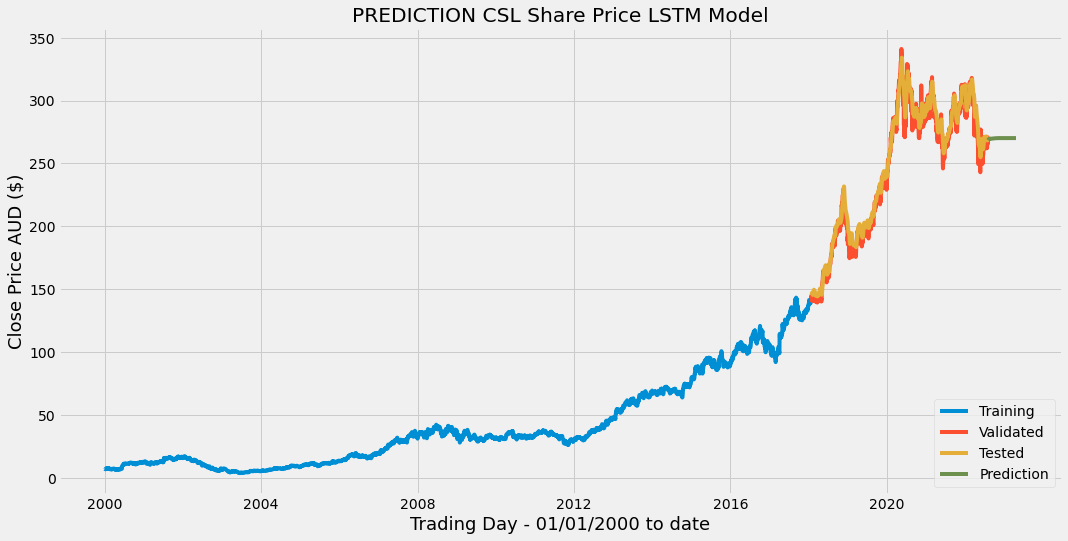

In [40]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:df_len] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[df_len:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION CSL Share Price LSTM Model')
plt.xlabel('Trading Day - 01/01/2000 to date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training','Validated','Tested','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.show()

#Save predicted price to MongoDB

In [ ]:
# # Module used to connect Python with MongoDb
# import pymongo

In [ ]:
# # The default port used by MongoDB is 27017
# # https://docs.mongodb.com/manual/reference/default-mongodb-port/
# conn = 'mongodb://localhost:27017'
# client = pymongo.MongoClient(conn)

# # Define the 'sharesDB' database in Mongo
# db = client.sharesDB

In [ ]:
# # Query all
# # Here, db.companys refers to the collection 'companys '
# companys = db.companys.find()

# # Iterate through each company in the collection
# for company in companys:
#     print(company)

In [ ]:
# # Set keys and values of company
# name = 'CSL'
# predicted = int(pred_price)
# difference = pred_price-actual_price
# print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference}')

In [ ]:
# # Insert a document into the 'companys' collection
# db.companys.insert_one(
#     {
#       'model': 'LSTM',
#       'name': name,
#       'date': actual_date,
#       'predicted': predicted,
#       'actual': actual_price,
#       'differece': difference
#     }
# )

# # query the classroom collection
# companys = db.companys.find()

# # see change in collection
# for company in companys:
#     print(company)

In [ ]:
# # Delete a document from a collection
# db.companys.delete_one(
#     {'name': 'CSL'}
# )

# # query the companys collection
# companys = db.companys.find()

# # see change in the collection
# for company in companys:
#     print(company)

In [ ]:
# from pymongo import MongoClient
# mongoClient = MongoClient()
# db = mongoClient.sharesDB
# db.csl.drop()

# import csv
# header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
# csvfile = open('../static/data/csl.csv', 'r')
# reader = csv.DictReader( csvfile )

# for each in reader:
#     row={}
#     for field in header:
#         row[field]=each[field]
        
#     print (row)
#     db.csl.insert_one(row)				

In [ ]:
# # query the collection
# csls = db.csl.find()

# # see change in collection
# for csl in csls:
#     print(csl)